Following is a python notebook simulating a spin-1/2 1D chain for the hamiltonian given by

$$
  \hat{H} = -J \sum_{j=1}^{N-1} (\hat{\sigma}_{j}^{x} \hat{\sigma}_{j+1}^{x} + \hat{\sigma}_{j}^{y} \hat{\sigma}_{j+1}^{y}) + U \sum_{j=1}^{N-1} \hat{\sigma}_{j}^{z} \hat{\sigma}_{j+1}^{z} + \sum_{j=1}^{N} h_j\hat{\sigma}_{j}^{z}
$$

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Step 1 - Functions for implementing the circuit**

For implementing the Hamiltonian, symmetric trotter decomposition is used as shown here.

<div>
<center>
<img src="Images/Symm_decomp.png" width="250"/>
</center>
</div>

where,

$$
    {\hat{A}}_{j}={e}^{-i{h}_{j}{\hat{\sigma }}_{j}^{z}\frac{\Delta t}{2}},\quad {\hat{B}}_{j}={e}^{-i(U{\hat{\sigma }}_{j}^{z}{\hat{\sigma }}_{j+1}^{z}-J({\hat{\sigma }}_{j}^{x}{\hat{\sigma }}_{j+1}^{x}+{\hat{\sigma }}_{j}^{y}{\hat{\sigma }}_{j+1}^{y}))\frac{\Delta t}{2}},{\hat{C}}_{j}={e}^{-i(U{\hat{\sigma }}_{j}^{z}{\hat{\sigma }}_{j+1}^{z}-J({\hat{\sigma }}_{j}^{x}{\hat{\sigma }}_{j+1}^{x}+{\hat{\sigma }}_{j}^{y}{\hat{\sigma }}_{j+1}^{y}))\Delta t}
$$


The 2 qubit gates of the form 

$$
    N(\alpha ,\beta ,\gamma )=\exp \left[i\left(\alpha {\sigma }^{x}\otimes {\sigma }^{x}+\beta {\sigma }^{y}\otimes {\sigma }^{y}+\gamma {\sigma }^{z}\otimes {\sigma }^{z}\right)\right]
$$

can be implemented by the following circuit

<div>
<center>
<img src="Images/2Q_circuit.png" width="350"/>
</center>
</div>



In [2]:
#Components to build circuit
def block_for_trotter_step_Bj_Cj(alpha, beta, gamma, my_circuit, wire1, wire2):
    theta = np.pi/2 - 2 * gamma
    phi = 2 * alpha - np.pi/2
    lamda = np.pi/2 - 2 * beta

    my_circuit.rz(-np.pi/2, wire2)
    my_circuit.cnot(wire2, wire1)
    my_circuit.rz(theta, wire1)
    my_circuit.ry(phi, wire2)
    my_circuit.cnot(wire1, wire2)
    my_circuit.ry(lamda, wire2)
    my_circuit.cnot(wire2, wire1)
    my_circuit.rz(np.pi/2, wire1)

def block_for_trotter_step_Aj(delta, my_circuit, wire):
    my_circuit.rz(delta, wire)

def trotter_step_symmetric(my_circuit, N, alpha, beta, gamma=0, delta=0):
    #Ajs
    for i in range(0, N, 1):
        block_for_trotter_step_Aj(delta[i], my_circuit, i)
    #Bjs
    for i in range(1, N-1,2):
        block_for_trotter_step_Bj_Cj(alpha/2, beta/2, gamma, my_circuit, i, i+1)

    #Cjs
    for i in range(0, N-1, 2):
        block_for_trotter_step_Bj_Cj(alpha, beta, gamma, my_circuit, i, i+1)
    #Bjs
    for i in range(1, N-1,2):
        block_for_trotter_step_Bj_Cj(alpha/2, beta/2, gamma, my_circuit, i, i+1)

    #Ajs
    for i in range(0, N, 1):
        block_for_trotter_step_Aj(delta[i], my_circuit, i)
        
def trotterized_circuit(my_circuit, N, alpha, beta, gamma, delta, no_trotter_steps):
    for i in range(round(no_trotter_steps)):
        trotter_step_symmetric(my_circuit, N, alpha, beta, gamma, delta)    

def Measurement(my_circuit):
    my_circuit.measure_all()


**Step 2 - Defining the Observables**

*Local Magnetization*

$$
    {M}_{j}(t)=\langle \psi (t)|{\hat{\sigma }}_{j}^{z}|\psi (t)\rangle
$$

$$
    \left\langle \psi (t)\right|{\hat{\sigma }}_{j}^{z}\left|\psi (t)\right\rangle =\sum _{\lambda :j=\uparrow }| {\alpha }_{\lambda }{| }^{2}-\sum _{\lambda ^{\prime} :j=\downarrow }| {\alpha }_{\lambda ^{\prime} }{| }^{2},
$$


*Nhalf*

$$
    {N}_{\text{half}}(t)=\sum _{j=1}^{N/2}\left\langle \psi (t)\right|\ \frac{{\hat{\sigma }}_j^{z}+1}{2}\ \left|\psi (t)\right\rangle
$$

In [3]:
#Observables    
def observable_magnetization(probabilities, site):
    magnetization = 0
    for i in probabilities.keys():
        if i[site-1] == '0':
            magnetization += probabilities[i] #as prob is already alpha^2
        else:
            magnetization -= probabilities[i]
    return magnetization

def Nhalf(probabilities, N):
    Nhalf = 0
    for i in range(round(N/2)):
        Nhalf += observable_magnetization(probabilities, i+1)
    Nhalf = 0.5 * (N/2 + Nhalf)
    return Nhalf

**Step 3 - Verification of Results from the [Reference Paper](https://www.nature.com/articles/s41534-019-0217-0)**


In [42]:
# Simulated Case - The XX chain with 200 trotter steps

J = 1
dt = 0.2
t_end = 10
result_magnetization_finer_case1 = []
t_final_finer_case1 = []
circuits = []

for i in np.arange(dt, t_end+dt, dt):
    t_final_finer_case1.append(i)
    
#Parameters
N = 6
no_shots = 8192
h = 0
U = 0
h_arr = np.linspace(-h, h, N)
site = 6
no_trotter_steps = 200


for t in t_final_finer_case1:
    dt = t / no_trotter_steps
    alpha = J * dt
    beta = J * dt
    gamma = -U*dt
    delta = h_arr * dt

    my_circuit = QuantumCircuit(N)

    #preparing the initial state - domain wall (000111)
    for i in range(int(N/2), N):
        my_circuit.x(i)

    trotterized_circuit(my_circuit, N, alpha, beta, gamma, delta, no_trotter_steps)

    Measurement(my_circuit)
    circuits.append(my_circuit)
    
    simulator = AerSimulator()
    compiled_circuit = transpile(my_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=no_shots)

    count = job.result().get_counts(compiled_circuit)

    probabilities = count
    for i in probabilities.keys():
        probabilities[i] =probabilities[i]/no_shots 

    result_magnetization_finer_case1.append(observable_magnetization(probabilities, site))

Text(0, 0.5, 'Magnetization site 6')

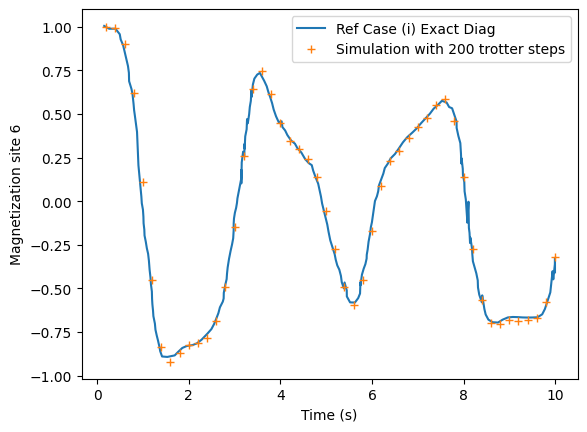

In [53]:
df_paper_NM = pd.read_csv('./Papers/Data from Papers/Paper Magn site 6 NM.csv')
df_paper_exact = pd.read_csv('./Papers/Data from Papers/Paper Magn site 6 ED.csv')

plt.plot(df_paper_exact.iloc[:,0], df_paper_exact.iloc[:,1], label='Ref Case (i) Exact Diag')
plt.plot(t_final_finer_case1, result_magnetization_finer_case1,'+', label='Simulation with 200 trotter steps')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Magnetization site 6')


**Step 4 - Study of the XX chain**

For the XX chain, h = 0 and U = 0 in the Hamiltonian.


Text(0.5, 1.0, 'Evolution of local magnetization')

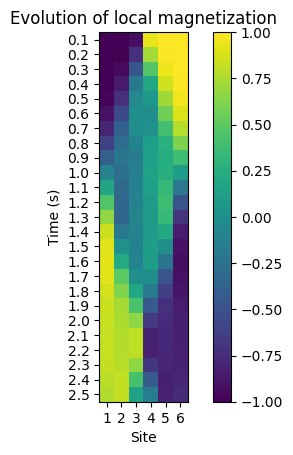

In [17]:
# Case 1 - The XX chain - site local magnetization contour

J = 1
dt = 0.1
t_end = 2.5
t_final_case1 = []
circuits = []

for i in np.arange(dt, t_end+dt, dt):
    t_final_case1.append(i)
    
#Parameters
N = 6
no_shots = 8192
h = 0
U = 0
h_arr = np.linspace(-h, h, N)
site = 6
no_trotter_steps = 50

contour_magn = []
for t in t_final_case1:
    dt = t / no_trotter_steps
    alpha = J * dt
    beta = J * dt
    gamma = -U*dt
    delta = h_arr * dt

    my_circuit = QuantumCircuit(N)

    #preparing the initial state - domain wall (000111)
    for i in range(int(N/2), N):
        my_circuit.x(i)

    trotterized_circuit(my_circuit, N, alpha, beta, gamma, delta, no_trotter_steps)

    Measurement(my_circuit)
    circuits.append(my_circuit)
    
    simulator = AerSimulator()
    compiled_circuit = transpile(my_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=no_shots)

    count = job.result().get_counts(compiled_circuit)

    probabilities = count
    for i in probabilities.keys():
        probabilities[i] =probabilities[i]/no_shots 

    result_magnetization_case1 = []
    for i in range(1, N+1):
        result_magnetization_case1.append(observable_magnetization(probabilities, i))
    
    contour_magn.append(result_magnetization_case1)

plt.xticks(np.arange(N))
plt.yticks(np.arange(len(t_final_case1)))
plt.imshow(contour_magn)
ax = plt.gca()
ax.set_xticklabels(np.arange(1, N+1))
ax.set_yticklabels(np.array(t_final_case1).round(2))
plt.colorbar()
plt.xlabel('Site')
plt.ylabel('Time (s)')
plt.title('Evolution of local magnetization')

Text(0, 0.5, 'Magnetization site 6')

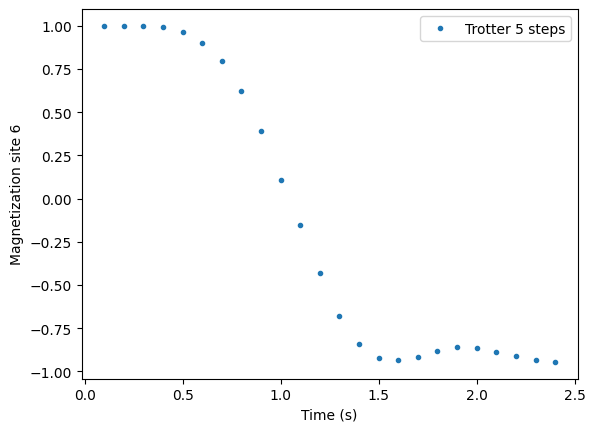

In [13]:
# Case 1 - The XX chain - 5 trotter steps

J = 1
dt = 0.1
t_end = 2.5
result_magnetization_case1 = []
t_final_case1 = []
circuits = []

for i in np.arange(dt, t_end, dt):
    t_final_case1.append(i)
    
#Parameters
N = 6
no_shots = 8192
h = 0
U = 0
h_arr = np.linspace(-h, h, N)
site = 6
no_trotter_steps = 5


for t in t_final_case1:
    dt = t / no_trotter_steps
    alpha = J * dt
    beta = J * dt
    gamma = -U*dt
    delta = h_arr * dt

    my_circuit = QuantumCircuit(N)

    #preparing the initial state - domain wall (000111)
    for i in range(int(N/2), N):
        my_circuit.x(i)

    trotterized_circuit(my_circuit, N, alpha, beta, gamma, delta, no_trotter_steps)

    Measurement(my_circuit)
    circuits.append(my_circuit)
    
    simulator = AerSimulator()
    compiled_circuit = transpile(my_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=no_shots)

    count = job.result().get_counts(compiled_circuit)

    probabilities = count
    for i in probabilities.keys():
        probabilities[i] =probabilities[i]/no_shots 

    result_magnetization_case1.append(observable_magnetization(probabilities, site))

plt.plot(t_final_case1, result_magnetization_case1, '.', label='Trotter 5 steps')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Magnetization site 6')


In [ ]:
# Running simulations on QC - an example

from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()
import time
backend = provider.get_backend("ibm_nairobi")

result_magnetization_qc = []
job_ids = []
for i in range(len(t_final_case1)):
    transpiled = transpile(circuits[i], backend=backend)

    # Submit a job.
    job = backend.run(transpiled, shots=no_shots)

    job_ids.append(job.job_id())
    time.sleep(5)

f = open("./QC data/Case 1/QC_IBM_nairobi_optim_fixed_trotter_steps=5_job_IDs_trial2.txt", "w")
for i in job_ids:
    f.write(i+'\n')
f.close()

In [15]:
#Retreiving results from QC

from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()
backend = provider.get_backend("ibm_nairobi")
t_final_qc = t_final_case1
f = open("./QC data/Case 1/QC_IBM_nairobi_optim_fixed_trotter_steps=5_job_IDs_trial2.txt", "r")
data = f.read()
job_id_from_file = data.split('\n')
job_id_from_file.pop() #one extra empty string removed from end of list

result_magnetization_qc = []
for i in range(len(job_id_from_file)):
    # Get results.
    job = provider.backend.retrieve_job(job_id_from_file[i])
    count = job.result().get_counts()

    probabilities = count
    for i in probabilities.keys():
        probabilities[i] =probabilities[i]/no_shots 

    result_magnetization_qc.append(observable_magnetization(probabilities, site))

Text(0.5, 1.0, 'Case (i) Trotter steps = 5')

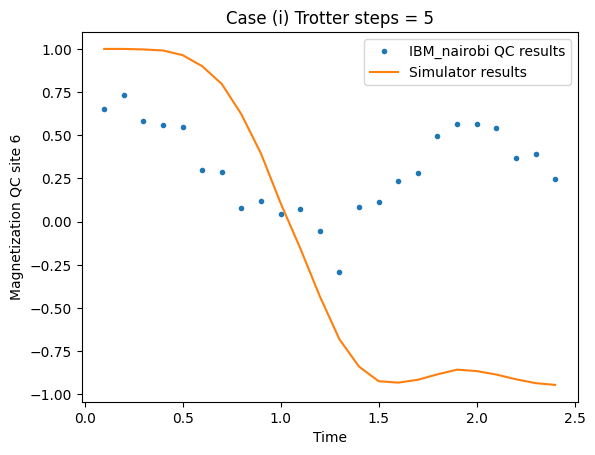

In [16]:
plt.plot(t_final_qc, result_magnetization_qc,'.', label='IBM_nairobi QC results')
plt.plot(t_final_case1, result_magnetization_case1, label='Simulator results')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Magnetization QC site 6')
plt.title('Case (i) Trotter steps = 5')

**Step 5 - Parametric study on influence of number of trotter step and number of qubits for XX chain simulation on quantum computer**

Results show that with lower number of trotter steps (lower circuit depth) and less number of particles (lower qubits), we get more accurate results as expected.


*Part 1 - number of trotter steps*

In [98]:
#Trotter steps 3
J = 1
dt = 0.2
t_end = 2
result_magnetization_case1 = []
t_final_case1 = []
circuits = []

for i in np.arange(dt, t_end+dt, dt):
    t_final_case1.append(i)
    
#Parameters
N = 6
no_shots = 8192
h = 0
U = 0
h_arr = np.linspace(-h, h, N)
site = 6
no_trotter_steps = 3

for t in t_final_case1:
    dt = t / no_trotter_steps
    alpha = J * dt
    beta = J * dt
    gamma = -U*dt
    delta = h_arr * dt

    my_circuit = QuantumCircuit(N)

    #preparing the initial state - domain wall (000111)
    for i in range(int(N/2), N):
        my_circuit.x(i)

    trotterized_circuit(my_circuit, N, alpha, beta, gamma, delta, no_trotter_steps)

    Measurement(my_circuit)
    circuits.append(my_circuit)
    
    simulator = AerSimulator()
    compiled_circuit = transpile(my_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=no_shots)

    count = job.result().get_counts(compiled_circuit)

    probabilities = count
    for i in probabilities.keys():
        probabilities[i] =probabilities[i]/no_shots 

    result_magnetization_case1.append(observable_magnetization(probabilities, site))

In [96]:
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()
from matplotlib import pyplot as plt
%matplotlib inline
backend = provider.get_backend("ibm_nairobi")
t_final_qc = t_final_case1
f = open("./QC data/Case 1/QC_IBM_nairobi_optim_fixed_trotter_steps=3_job_IDs_trial2.txt", "r")
data = f.read()
job_id_from_file = data.split('\n')
job_id_from_file.pop() #one extra empty string removed from end of list

result_magnetization_qc = []
for i in range(len(job_id_from_file)):
    # Get results.
    job = provider.backend.retrieve_job(job_id_from_file[i])
    count = job.result().get_counts()

    probabilities = count
    for i in probabilities.keys():
        probabilities[i] =probabilities[i]/no_shots 

    result_magnetization_qc.append(observable_magnetization(probabilities, site))

Text(0.5, 1.0, 'Case (i) Trotter steps = 3')

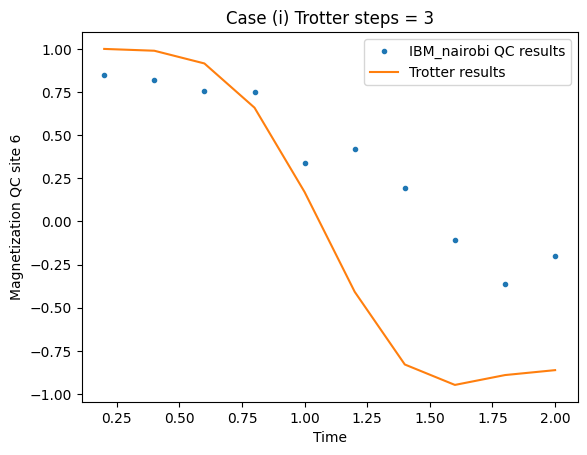

In [99]:
plt.plot(t_final_qc, result_magnetization_qc,'.', label='IBM_nairobi QC results')
plt.plot(t_final_case1, result_magnetization_case1, label='Trotter results')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Magnetization QC site 6')
plt.title('Case (i) Trotter steps = 3')

Text(0.5, 1.0, 'Case (i) Trotter steps = 2')

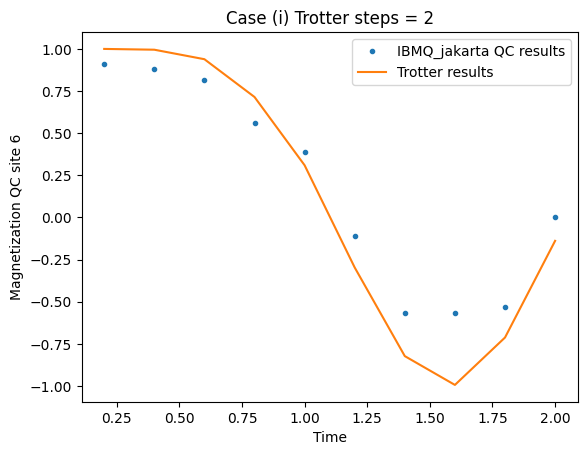

In [108]:
#Trotter steps 2
J = 1
dt = 0.2
t_end = 2
result_magnetization_case1 = []
t_final_case1 = []
circuits = []

for i in np.arange(dt, t_end+dt, dt):
    t_final_case1.append(i)
    
#Parameters
N = 6
no_shots = 8192
h = 0
U = 0
h_arr = np.linspace(-h, h, N)
site = 6
no_trotter_steps = 2

for t in t_final_case1:
    dt = t / no_trotter_steps
    alpha = J * dt
    beta = J * dt
    gamma = -U*dt
    delta = h_arr * dt

    my_circuit = QuantumCircuit(N)

    #preparing the initial state - domain wall (000111)
    for i in range(int(N/2), N):
        my_circuit.x(i)

    trotterized_circuit(my_circuit, N, alpha, beta, gamma, delta, no_trotter_steps)

    Measurement(my_circuit)
    circuits.append(my_circuit)
    
    simulator = AerSimulator()
    compiled_circuit = transpile(my_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=no_shots)

    count = job.result().get_counts(compiled_circuit)

    probabilities = count
    for i in probabilities.keys():
        probabilities[i] =probabilities[i]/no_shots 

    result_magnetization_case1.append(observable_magnetization(probabilities, site))

from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()
from matplotlib import pyplot as plt
%matplotlib inline
backend = provider.get_backend("ibm_nairobi")
t_final_qc = t_final_case1
f = open("./QC data/Case 1/QC_IBM_nairobi_optim_fixed_trotter_steps=2_job_IDs_trial1.txt", "r")
data = f.read()
job_id_from_file = data.split('\n')
job_id_from_file.pop() #one extra empty string removed from end of list

result_magnetization_qc = []
for i in range(len(job_id_from_file)):
    # Get results.
    job = provider.backend.retrieve_job(job_id_from_file[i])
    count = job.result().get_counts()

    probabilities = count
    for i in probabilities.keys():
        probabilities[i] =probabilities[i]/no_shots 

    result_magnetization_qc.append(observable_magnetization(probabilities, site))



Text(0.5, 1.0, 'Case (i) Trotter steps = 2')

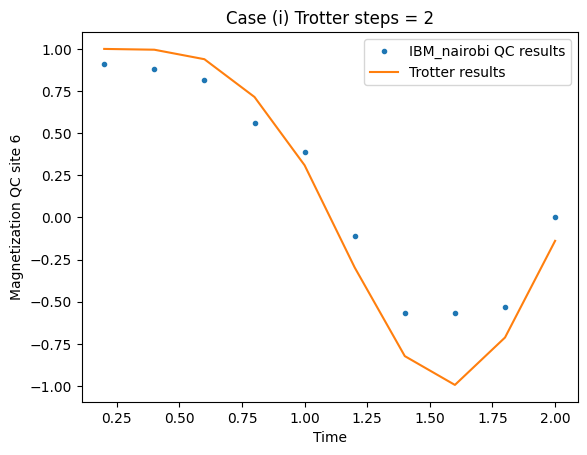

In [109]:
plt.plot(t_final_qc, result_magnetization_qc,'.', label='IBM_nairobi QC results')
plt.plot(t_final_case1, result_magnetization_case1, label='Trotter results')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Magnetization QC site 6')
plt.title('Case (i) Trotter steps = 2')

*Part 2 - Number of qubits*

Comparision of 6 and 4 qubit systems.

Text(0.5, 1.0, 'Case (i) Trotter steps = 5')

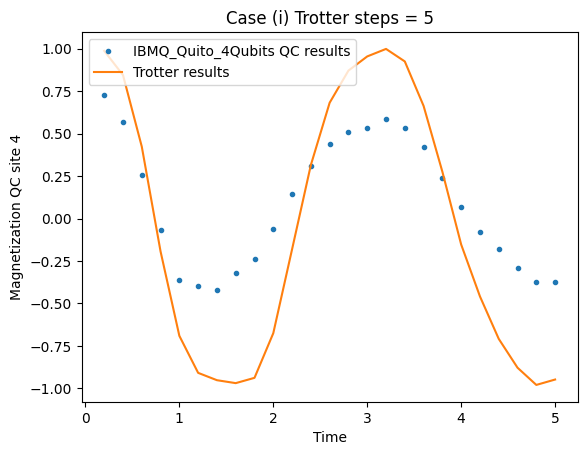

In [112]:
#Trotter steps 5
J = 1
dt = 0.2
t_end = 5
result_magnetization_case1 = []
t_final_case1 = []
circuits = []

for i in np.arange(dt, t_end+dt, dt):
    t_final_case1.append(i)
    
#Parameters
N = 4
no_shots = 8192
h = 0
U = 0
h_arr = np.linspace(-h, h, N)
site = 4
no_trotter_steps = 5

for t in t_final_case1:
    dt = t / no_trotter_steps
    alpha = J * dt
    beta = J * dt
    gamma = -U*dt
    delta = h_arr * dt

    my_circuit = QuantumCircuit(N)

    #preparing the initial state - domain wall (000111)
    for i in range(int(N/2), N):
        my_circuit.x(i)

    trotterized_circuit(my_circuit, N, alpha, beta, gamma, delta, no_trotter_steps)

    Measurement(my_circuit)
    circuits.append(my_circuit)
    
    simulator = AerSimulator()
    compiled_circuit = transpile(my_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=no_shots)

    count = job.result().get_counts(compiled_circuit)

    probabilities = count
    for i in probabilities.keys():
        probabilities[i] =probabilities[i]/no_shots 

    result_magnetization_case1.append(observable_magnetization(probabilities, site))

from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()
from matplotlib import pyplot as plt
%matplotlib inline
backend = provider.get_backend("ibmq_quito")
t_final_qc = t_final_case1
f = open("./QC data/Case 1/QC_IBMQ_quito_optim_fixed_trotter_steps_5_tfinal_5_N4_job_IDs.txt", "r")
data = f.read()
job_id_from_file = data.split('\n')
job_id_from_file.pop() #one extra empty string removed from end of list

result_magnetization_qc = []
for i in range(len(job_id_from_file)):
    # Get results.
    job = provider.backend.retrieve_job(job_id_from_file[i])
    count = job.result().get_counts()

    probabilities = count
    for i in probabilities.keys():
        probabilities[i] =probabilities[i]/no_shots 

    result_magnetization_qc.append(observable_magnetization(probabilities, site))

plt.plot(t_final_qc, result_magnetization_qc,'.', label='IBMQ_Quito_4Qubits QC results')
plt.plot(t_final_case1, result_magnetization_case1, label='Trotter results')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Magnetization QC site 4')
plt.title('Case (i) Trotter steps = 5')

**Step 6 - Study of the Disordered XX chain**

For the Disordered XX chain, U = 0 in the Hamiltonian.

h = 0 and h = 10 are studied. As h increases, the extent of spreading of domain wall is decreasing.

Text(0.5, 1.0, 'Evolution of local magnetization h = 0')

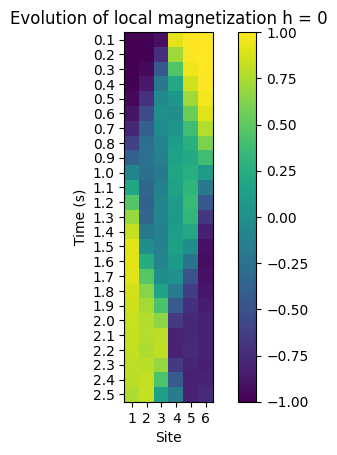

In [4]:
# Case 2 - Disordered XX chain - contour, h = 0

J = 1
dt = 0.1
t_end = 2.5
t_final_case2 = []
circuits = []

for i in np.arange(dt, t_end+dt, dt):
    t_final_case2.append(i)
    
#Parameters
N = 6
no_shots = 8192
h = 0
U = 0
h_arr = np.linspace(-h, h, N)
site = 6
no_trotter_steps = 50

contour_magn = []
for t in t_final_case2:
    dt = t / no_trotter_steps
    alpha = J * dt
    beta = J * dt
    gamma = -U*dt
    delta = h_arr * dt

    my_circuit = QuantumCircuit(N)

    #preparing the initial state - domain wall (000111)
    for i in range(int(N/2), N):
        my_circuit.x(i)

    trotterized_circuit(my_circuit, N, alpha, beta, gamma, delta, no_trotter_steps)

    Measurement(my_circuit)
    circuits.append(my_circuit)
    
    simulator = AerSimulator()
    compiled_circuit = transpile(my_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=no_shots)

    count = job.result().get_counts(compiled_circuit)

    probabilities = count
    for i in probabilities.keys():
        probabilities[i] =probabilities[i]/no_shots 

    result_magnetization_case2 = []
    for i in range(1, N+1):
        result_magnetization_case2.append(observable_magnetization(probabilities, i))
    
    contour_magn.append(result_magnetization_case2)


plt.xticks(np.arange(N))
plt.yticks(np.arange(len(t_final_case2)))
plt.imshow(contour_magn)
ax = plt.gca()
ax.set_xticklabels(np.arange(1, N+1))
ax.set_yticklabels(np.array(t_final_case2).round(2))
plt.colorbar()
plt.xlabel('Site')
plt.ylabel('Time (s)')
plt.title('Evolution of local magnetization h = 0')

Text(0.5, 1.0, 'Evolution of local magnetization h = 10')

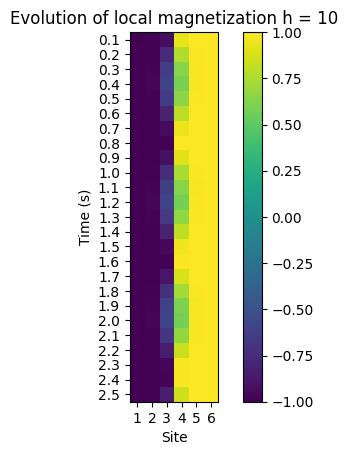

In [5]:
# Case 2 - Disordered XX chain - contour h = 10

J = 1
dt = 0.1
t_end = 2.5
t_final_case2 = []
circuits = []

for i in np.arange(dt, t_end+dt, dt):
    t_final_case2.append(i)
    
#Parameters
N = 6
no_shots = 8192
h = 10
U = 0
h_arr = np.linspace(-h, h, N)
site = 6
no_trotter_steps = 50

contour_magn = []
for t in t_final_case2:
    dt = t / no_trotter_steps
    alpha = J * dt
    beta = J * dt
    gamma = -U*dt
    delta = h_arr * dt

    my_circuit = QuantumCircuit(N)

    #preparing the initial state - domain wall (000111)
    for i in range(int(N/2), N):
        my_circuit.x(i)

    trotterized_circuit(my_circuit, N, alpha, beta, gamma, delta, no_trotter_steps)

    Measurement(my_circuit)
    circuits.append(my_circuit)
    
    simulator = AerSimulator()
    compiled_circuit = transpile(my_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=no_shots)

    count = job.result().get_counts(compiled_circuit)

    probabilities = count
    for i in probabilities.keys():
        probabilities[i] =probabilities[i]/no_shots 

    result_magnetization_case2 = []
    for i in range(1, N+1):
        result_magnetization_case2.append(observable_magnetization(probabilities, i))
    
    contour_magn.append(result_magnetization_case2)


plt.xticks(np.arange(N))
plt.yticks(np.arange(len(t_final_case2)))
plt.imshow(contour_magn)
ax = plt.gca()
ax.set_xticklabels(np.arange(1, N+1))
ax.set_yticklabels(np.array(t_final_case2).round(2))
plt.colorbar()
plt.xlabel('Site')
plt.ylabel('Time (s)')
plt.title('Evolution of local magnetization h = 10')

**Step 7 - Study of the XXZ chain**

For the XXZ chain, h = 0 in the Hamiltonian.

U = 0.25 and U = 1 are studied.

Text(0.5, 1.0, 'Evolution of local magnetization U = 0.25')

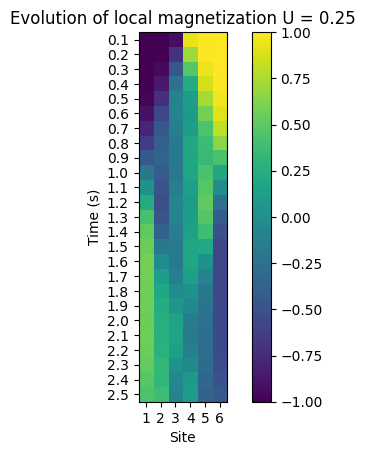

In [18]:
# Case 3 - XXZ chain - contour, U = 0.25

J = 1
dt = 0.1
t_end = 2.5
t_final_case3 = []
circuits = []

for i in np.arange(dt, t_end+dt, dt):
    t_final_case3.append(i)
    
#Parameters
N = 6
no_shots = 8192
h = 0
U = 0.25
h_arr = np.linspace(-h, h, N)
site = 6
no_trotter_steps = 50

contour_magn = []
for t in t_final_case3:
    dt = t / no_trotter_steps
    alpha = J * dt
    beta = J * dt
    gamma = -U*dt
    delta = h_arr * dt

    my_circuit = QuantumCircuit(N)

    #preparing the initial state - domain wall (000111)
    for i in range(int(N/2), N):
        my_circuit.x(i)

    trotterized_circuit(my_circuit, N, alpha, beta, gamma, delta, no_trotter_steps)

    Measurement(my_circuit)
    circuits.append(my_circuit)
    
    simulator = AerSimulator()
    compiled_circuit = transpile(my_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=no_shots)

    count = job.result().get_counts(compiled_circuit)

    probabilities = count
    for i in probabilities.keys():
        probabilities[i] =probabilities[i]/no_shots 

    result_magnetization_case3 = []
    for i in range(1, N+1):
        result_magnetization_case3.append(observable_magnetization(probabilities, i))
    
    contour_magn.append(result_magnetization_case3)


plt.xticks(np.arange(N))
plt.yticks(np.arange(len(t_final_case3)))
plt.imshow(contour_magn)
ax = plt.gca()
ax.set_xticklabels(np.arange(1, N+1))
ax.set_yticklabels(np.array(t_final_case3).round(2))
plt.colorbar()
plt.xlabel('Site')
plt.ylabel('Time (s)')
plt.title('Evolution of local magnetization U = 0.25')

Text(0.5, 1.0, 'Evolution of local magnetization U = 1')

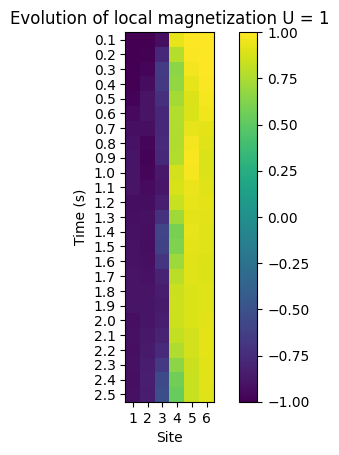

In [22]:
# Case 3 - XXZ chain - contour, U = 1

J = 1
dt = 0.1
t_end = 2.5
t_final_case3 = []
circuits = []

for i in np.arange(dt, t_end+dt, dt):
    t_final_case3.append(i)
    
#Parameters
N = 6
no_shots = 8192
h = 0
U = 1
h_arr = np.linspace(-h, h, N)
site = 6
no_trotter_steps = 50

contour_magn = []
for t in t_final_case3:
    dt = t / no_trotter_steps
    alpha = J * dt
    beta = J * dt
    gamma = -U*dt
    delta = h_arr * dt

    my_circuit = QuantumCircuit(N)

    #preparing the initial state - domain wall (000111)
    for i in range(int(N/2), N):
        my_circuit.x(i)

    trotterized_circuit(my_circuit, N, alpha, beta, gamma, delta, no_trotter_steps)

    Measurement(my_circuit)
    circuits.append(my_circuit)
    
    simulator = AerSimulator()
    compiled_circuit = transpile(my_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=no_shots)

    count = job.result().get_counts(compiled_circuit)

    probabilities = count
    for i in probabilities.keys():
        probabilities[i] =probabilities[i]/no_shots 

    result_magnetization_case3 = []
    for i in range(1, N+1):
        result_magnetization_case3.append(observable_magnetization(probabilities, i))
    
    contour_magn.append(result_magnetization_case3)


plt.xticks(np.arange(N))
plt.yticks(np.arange(len(t_final_case3)))
plt.imshow(contour_magn)
ax = plt.gca()
ax.set_xticklabels(np.arange(1, N+1))
ax.set_yticklabels(np.array(t_final_case3).round(2))
plt.colorbar()
plt.xlabel('Site')
plt.ylabel('Time (s)')
plt.title('Evolution of local magnetization U = 1')